In [3]:
import numpy as np
from base_notebook.pose_data_tools.graph import Graph
from base_notebook.pose_data_tools.generate_data import read_xyz
from base_notebook.pose_data_tools.preprocess import pre_normalization
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import os
import pandas as pd
import pickle

In [142]:
with open(PATH_LABELS, 'rb') as f:
    labels = pickle.load(f)
    df = pd.DataFrame(np.array([[x.split('/')[-1] for x in labels[0]], labels[1]]).T, columns=['filename', 'label'])
    df['label'] = df['label'].astype(np.int)
    
permitted = [LABEL]
idx = df.loc[df['label'].isin(permitted)].index
fname = os.path.join(PATH_RAW_TXT, df.loc[idx, 'filename'].iloc[SAMPLE])

In [149]:
# uncomment to specify the filename explicitly
fname = r"../iccv2021/_input/train/P082S04G10B00H40UC082000LC021000A010R0_09181009.txt"

In [150]:
data = read_xyz(fname, 2, 17)
data = data.reshape(1, *data.shape)

# if second person is missing
if np.all(data[0, :, :, :, 1] == 0):
    data = data[:, :, :, :, :1]
    
data = pre_normalization(data)[0]

100%|██████████| 1/1 [00:00<00:00, 290.02it/s]

Remove zero skeletons on both ends, and then pad the intermedia null frames with the next valid frames
lengths info:  150.0 150 150
sub the center joint of the first frame (spine joint in ntu and neck joint in kinetics)
rescale each object sequence to the range [0,1] while maintaing the high-width ratio


In [168]:
b

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [170]:
import tensorflow as tf
a = np.ones((1, 3, 1))
b = np.arange(9).reshape((3, 3))
tf.einsum('ijk,jl->ilk', a, b)

<tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[ 9.],
        [12.],
        [15.]]])>

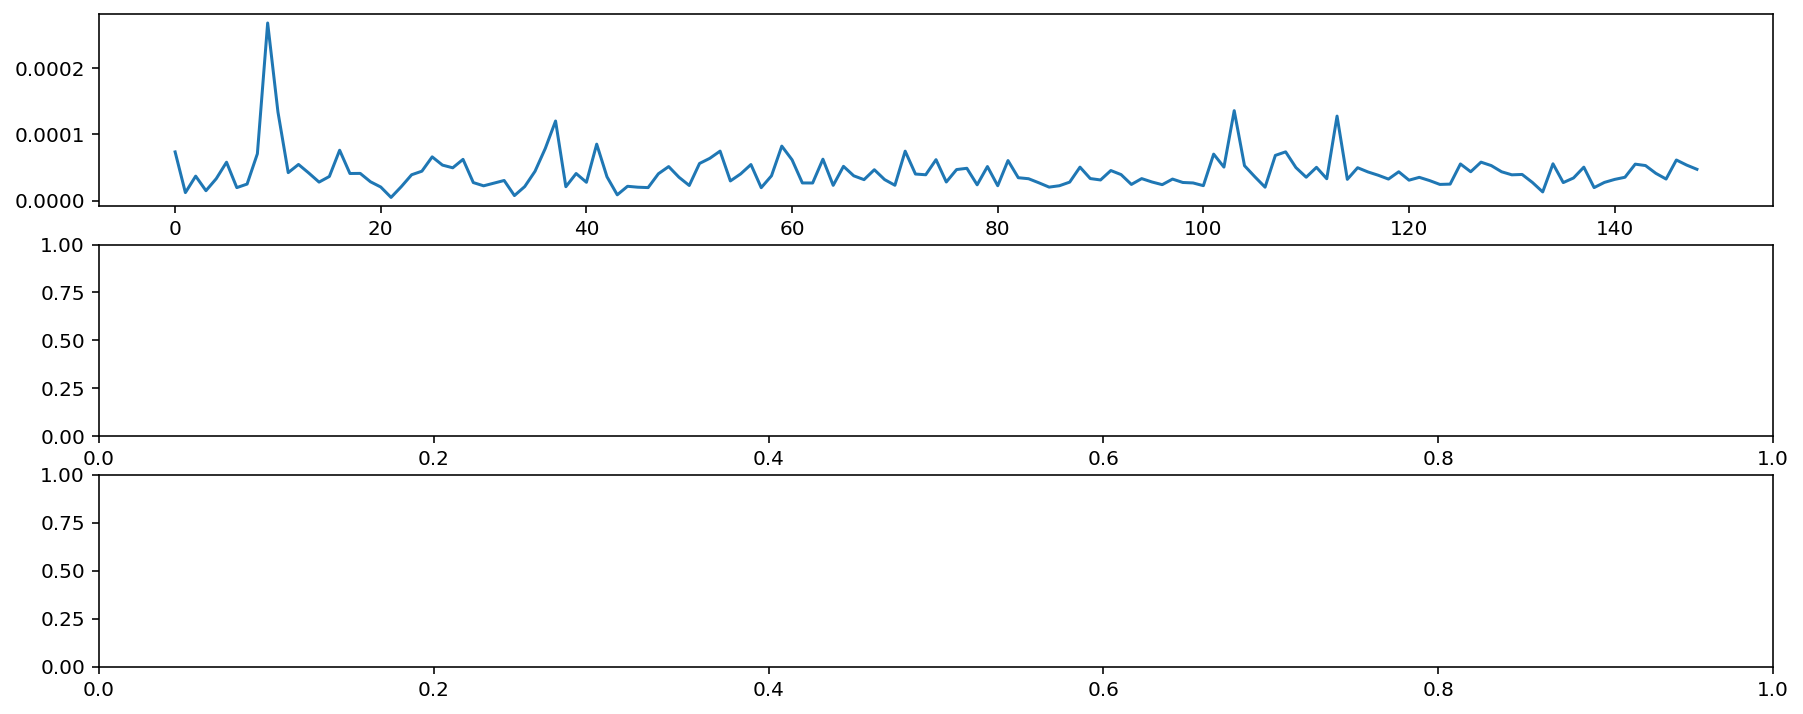

In [160]:
m2 = np.mean((data[sample_id, :, 1:, :, :] - data[sample_id, :, :-1, :, :]) ** 2, axis=(0, 2, 3))
fig, ax = plt.subplots(nrows=3, figsize=(15, 6))
ax[0].plot(m2)

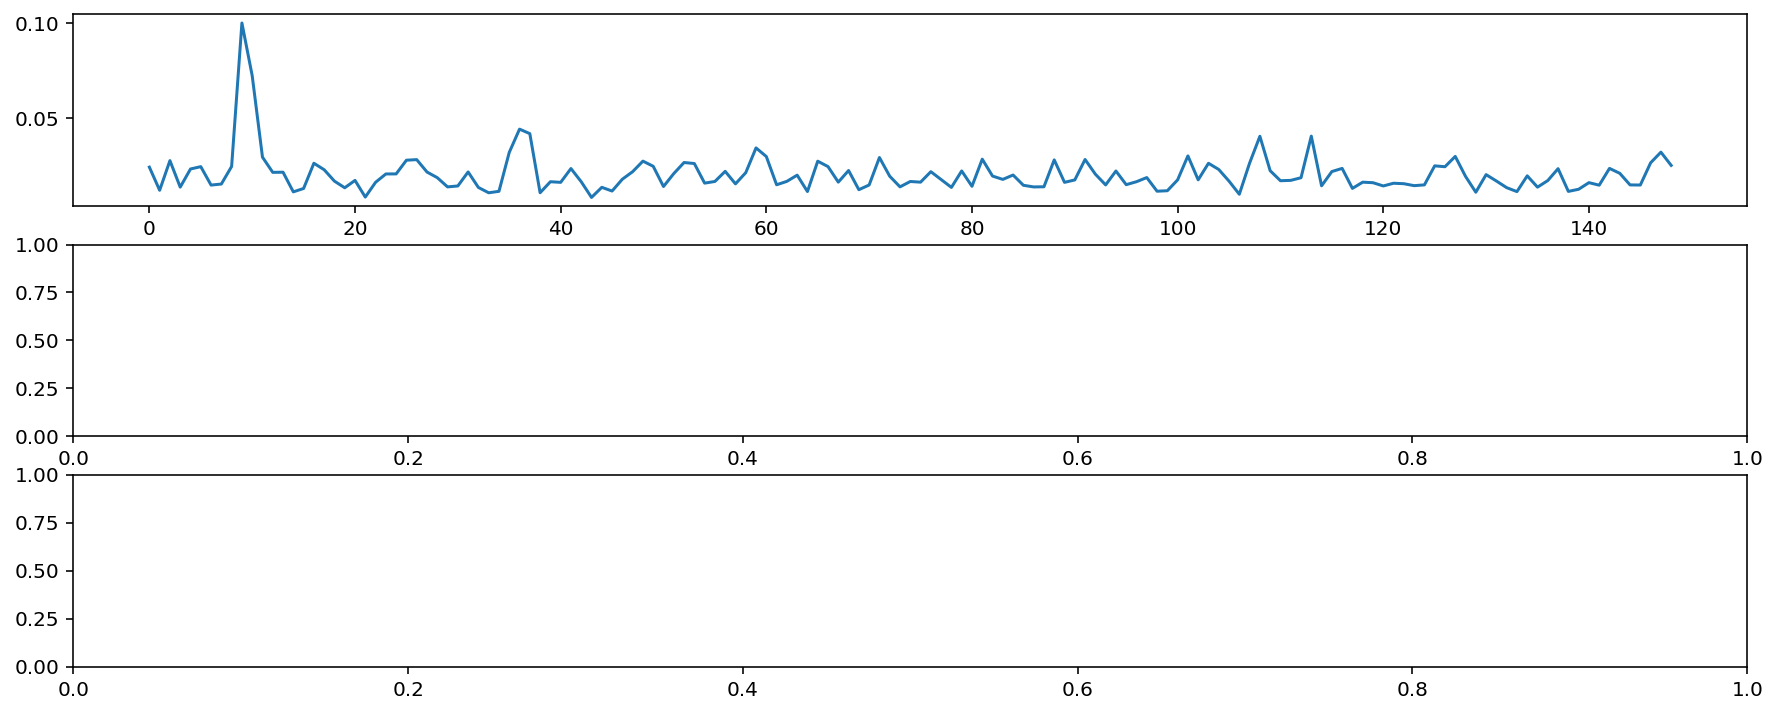

In [161]:
l2 = np.max(np.abs(data[sample_id, :, 1:, :, :] - data[sample_id, :, :-1, :, :]), axis=(0, 2, 3))
fig, ax = plt.subplots(nrows=3, figsize=(15, 6))
ax[0].plot(l2)

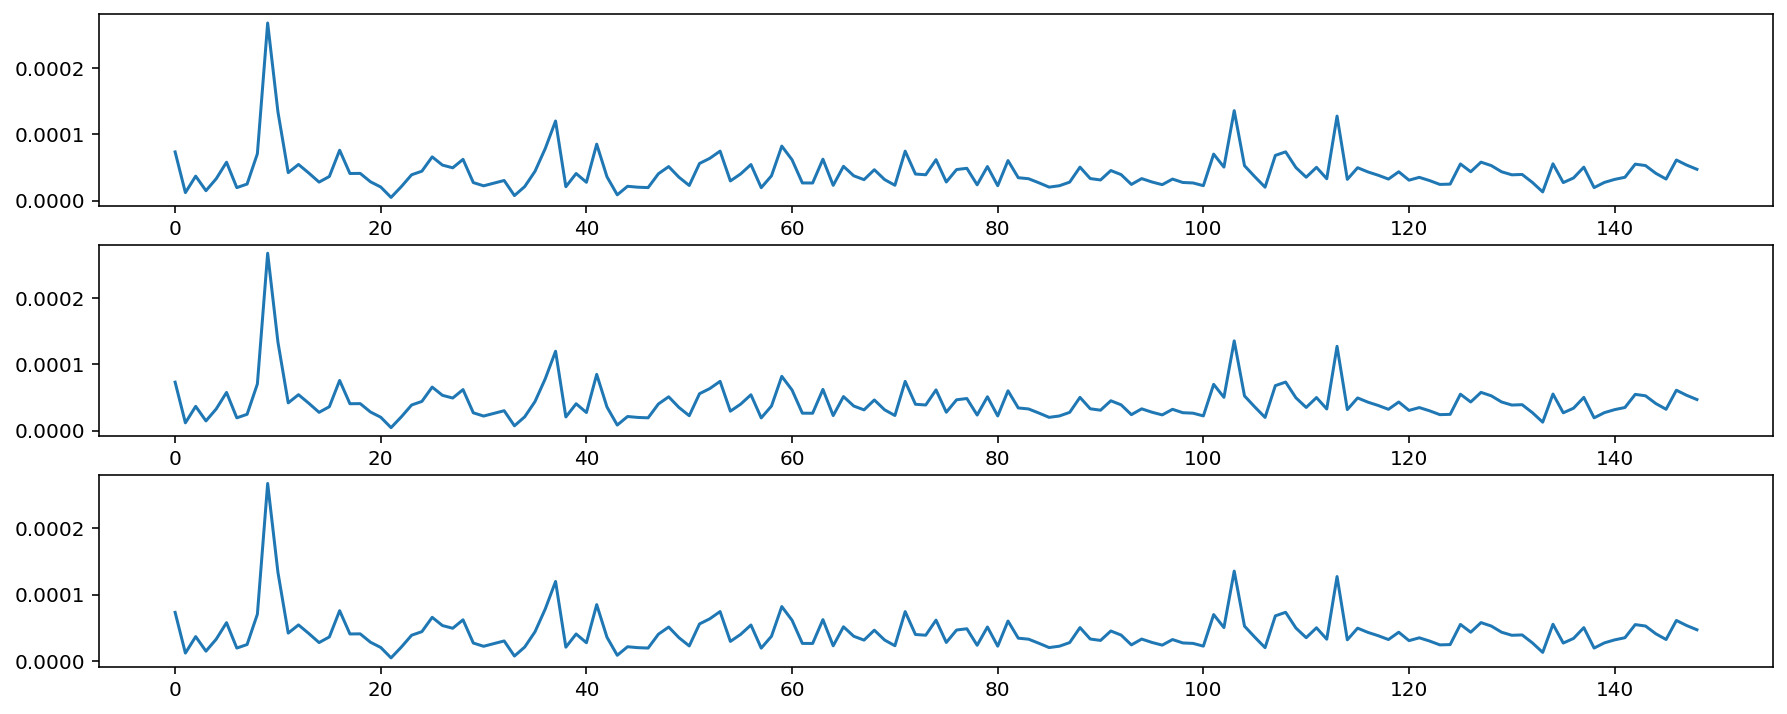

In [151]:
L2_THRESHOLD = 0.01
MIN_SEGMENT_LENGTH = 3
ADJ_THRESHOLD = 0.01


fig, ax = plt.subplots(nrows=3, figsize=(15, 6))

sample_id = 0

l2 = np.mean((data[sample_id, :, 1:, :, :] - data[sample_id, :, :-1, :, :]) ** 2, axis=(0, 2, 3))
ax[0].plot(l2)

# keep the first frame
mask = [True, *(l2 < L2_THRESHOLD)]
# data = data[:, :, np.array(mask), :, :]
l2 = np.mean((data[sample_id, :, 1:, :, :] - data[sample_id, :, :-1, :, :]) ** 2, axis=(0, 2, 3))
ax[2].plot(l2)

# segmentation

breakpoints = 1+np.arange(len(l2))[l2 > 0.01]
segments = np.split(data, breakpoints, axis=2)
segments = [segment for segment in segments if segment.shape[2] > MIN_SEGMENT_LENGTH]

longest_segment = sorted(segments, key=lambda x: x.shape[2])[-1]

# keep the first frame
mask = [True, *(l2 < L2_THRESHOLD)]
# data = data[:, :, np.array(mask), :, :]
l2 = np.mean((longest_segment[sample_id, :, 1:, :, :] - longest_segment[sample_id, :, :-1, :, :]) ** 2, axis=(0, 2, 3))
ax[1].plot(l2)

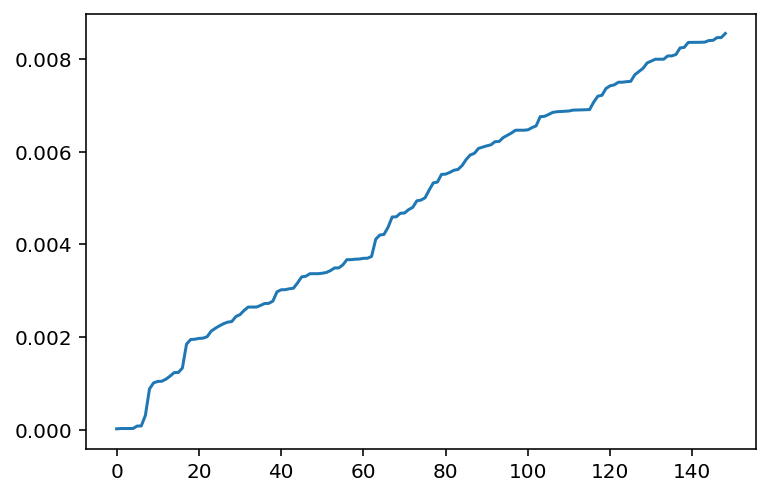

In [153]:
l2score = (data[:, :, 1:, :, :] - data[:, :, :-1, :, :]) ** 2
plt.plot(np.cumsum(l2score, 2)[0, 0, :, 0, 0])

In [37]:
adj_mat = np.array([[np.mean((s1[:, :, 0, :, :]-s2[:, :, 0, :, :])**2) for s1 in segments] for s2 in segments])
np.round(pd.DataFrame(adj_mat), 3).style.background_gradient(cmap='coolwarm', axis=None)

,0,1,2,3
0,0.000000,0.400000,0.396000,0.399000
1,0.400000,0.000000,0.000000,0.000000
2,0.396000,0.000000,0.000000,0.000000
3,0.399000,0.000000,0.000000,0.000000


In [38]:
edit = 1 + np.arange(len(segments)) + np.array([np.argmax(x[i+1:]) if (i+1 < len(adj_mat)) and (np.max(x[i+1:]) == 1) else np.nan for i, x in enumerate(adj_mat < ADJ_THRESHOLD)])

In [81]:
concats = []
left = np.ones(len(segments))

def x(q, left):
    if np.isnan(q):
        return []
    
    left[int(q)] = 0
    return [int(q), *x(edit[int(q)], left)]

while np.sum(left) > 0:
    q = np.argmax(left)
    concats += [x(q, left)]

samples = [np.concatenate([segments[i] for i in concat], axis=2) for concat in concats]

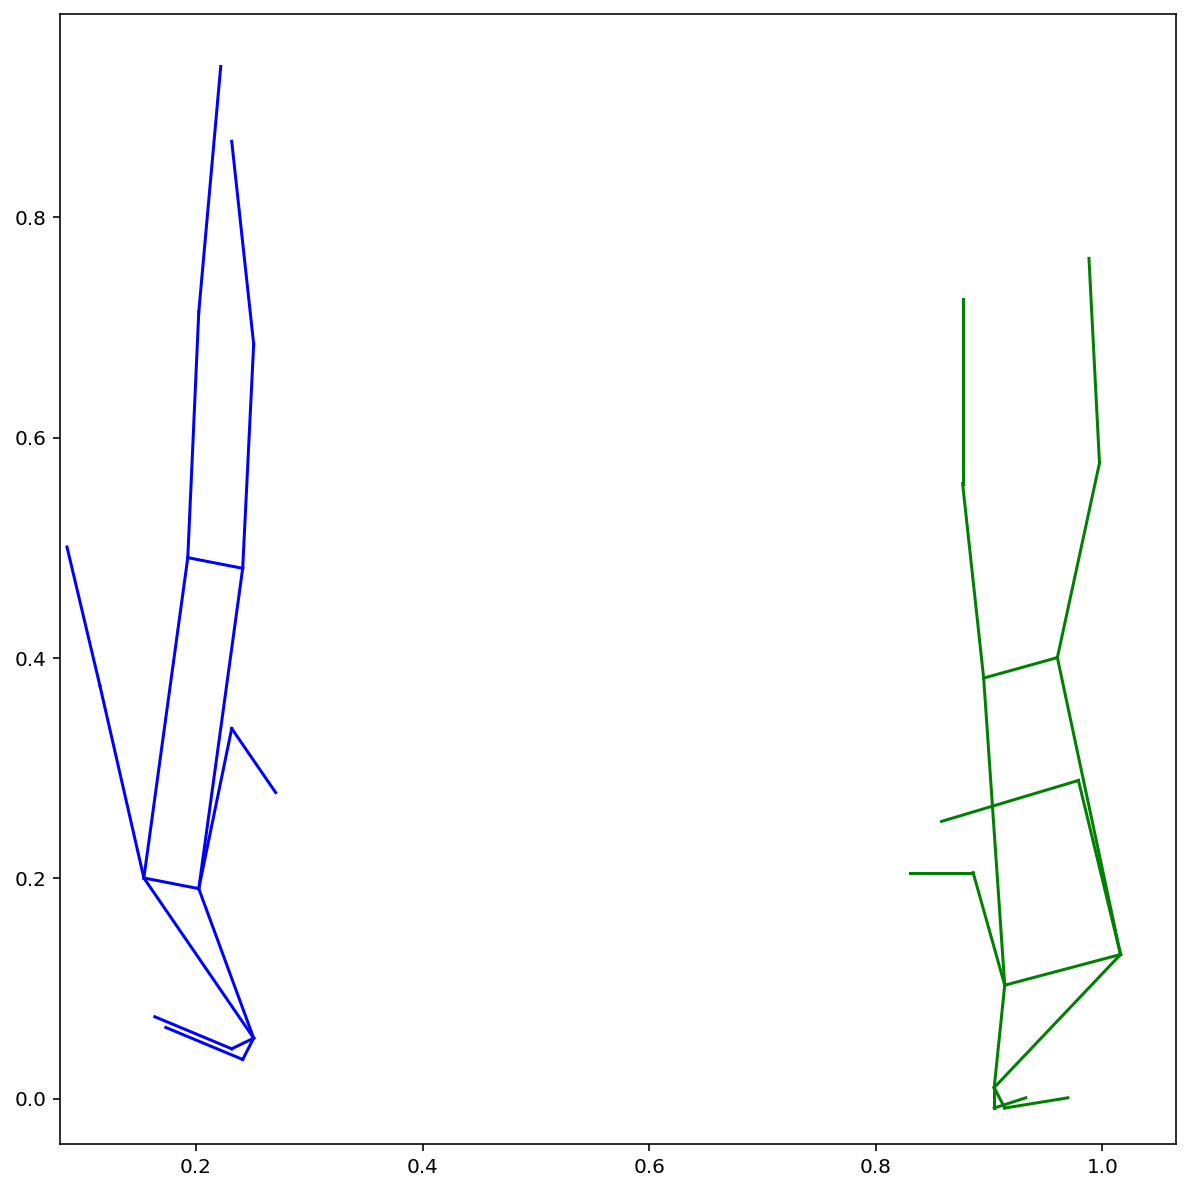

In [85]:
visualize(samples[1])

In [17]:
def visualize(data):

    N, C, T, V, M = data.shape

    x0, x1 = np.min(data[:, AXES[0], :, :, :]), np.max(data[:, AXES[0], :, :, :])
    y0, y1 = np.min(data[:, AXES[1], :, :, :]), np.max(data[:, AXES[1], :, :, :])

    ratio = (y1 - y0) / (x1 - x0)

    xh = 10
    yh = ratio * 10

    graph = Graph()
    fig, ax = plt.subplots(figsize=(xh, yh))

    plt.xlim((x0, x1))
    plt.ylim((y0, y1))

    edge = graph.inward

    p_type = ['b-', 'g-', 'g-', 'c-', 'm-', 'y-', 'k-', 'k-', 'k-', 'k-']
    pose = []

    for m in range(M):
        a = []
        for i in range(len(edge)):
            a.append(ax.plot(np.zeros(2), np.zeros(2), p_type[m])[0])
        pose.append(a)

    def animate(t):

        for m in range(M):

            for i, (v1, v2) in enumerate(edge):
                x1 = data[0, AXES, t, v1, m]
                x2 = data[0, AXES, t, v2, m]
                if (x1.sum() != 0 and x2.sum() != 0) or v1 == 1 or v2 == 1:
                    pose[m][i].set_xdata(data[0, AXES[0], t, [v1, v2], m])
                    pose[m][i].set_ydata(data[0, AXES[1], t, [v1, v2], m])

        return np.array(pose).flatten()

    anim = animation.FuncAnimation(fig, animate, frames=T, interval=20, blit=True)
    return HTML(anim.to_html5_video())